In [291]:
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModel
import matplotlib.pyplot as plt
import nltk
import string

In [292]:
df = pd.read_csv('./data/articles.csv')
df.head()

,article,source,labels
0,"When I first started looking at oil assets, I ...",own_source_lessthan50,0.0
1,We look at two airlines that have given Wall S...,own_source_morethan50,0.0
2,Disney's Animal Kingdom theme park is staging ...,own_source_lessthan50,0.0
3,Why should you think otherwise? If the effort ...,own_source_lessthan50,0.0
4,"Chris Murphy, Carolyn Maloney and Doug Jones i...",own_source_lessthan50,0.0


### Check the size of the datasets


In [293]:
real=df[df["labels"]==1.0]#[:100]
real.shape
generated=df[df["labels"]==0.0]#[:100]
generated.shape

(9944, 3)

### Plot the article lengths

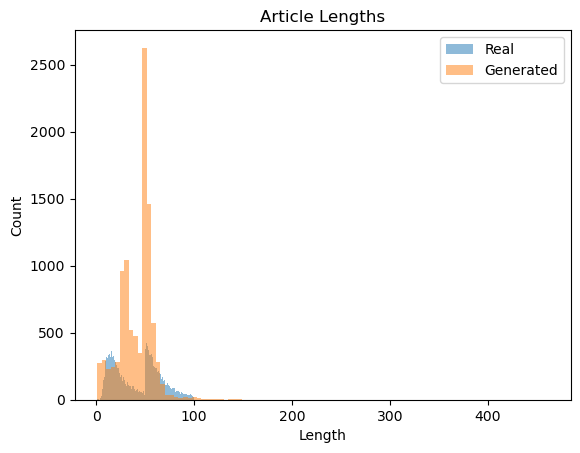

In [294]:
real_lengths = real['article'].apply(lambda x: len(nltk.sent_tokenize(x)))
generated_lengths = generated['article'].apply(lambda x: len(nltk.sent_tokenize(x)))
plt.hist(real_lengths, bins=100, alpha=0.5, label='Real')
plt.hist(generated_lengths, bins=100, alpha=0.5, label='Generated')

plt.title('Article Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

In [274]:
from collections import Counter
#downloading stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarynakorduba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yarynakorduba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Lookup common words

In [275]:
def lookup_common_words(articles, num_words = 20):
    words = []
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for article in articles:
        words.extend(nltk.word_tokenize(article.lower()))
    words = [word for word in words if word.isalpha() and word not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

real_words = lookup_common_words(real['article'])
generated_words = lookup_common_words(generated['article'])
print("Real common words: ", real_words, real.shape)
print("Fake common words: ", generated_words, generated.shape)

Real common words:  [('said', 93618), ('one', 32283), ('would', 29216), ('people', 26806), ('also', 25497), ('new', 23923), ('time', 20911), ('two', 20692), ('like', 19486), ('first', 18691), ('could', 18526), ('years', 17695), ('last', 17398), ('told', 17195), ('year', 15564), ('get', 15067), ('police', 14811), ('says', 13459), ('back', 13245), ('family', 12176)] (15000, 3)
Fake common words:  [('said', 86487), ('trump', 54195), ('would', 31854), ('also', 23506), ('new', 20712), ('president', 20451), ('people', 18418), ('one', 17636), ('could', 17103), ('state', 15966), ('government', 15915), ('reuters', 15059), ('states', 14384), ('house', 14286), ('republican', 13662), ('united', 12768), ('told', 12283), ('two', 12270), ('last', 12259), ('year', 11390)] (9944, 3)


# Text preprocessing

In [295]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
# large lexical database of English
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yarynakorduba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [296]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [297]:
def preprocess_article(article):
    # Lowercase the text
    article = article.lower()
    # Remove punctuation and digits, but leave the commas
    chars_to_omit = (string.punctuation + string.digits).replace(',', '')
    article = article.translate(str.maketrans('', '', chars_to_omit))
    # Convert the text into tokens
    words = word_tokenize(article)
    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Stem or lemmatize the words
    words = [stemmer.stem(word) for word in words]
   
    # Join the words back into a string
    article = ' '.join(words)

    return article

In [298]:
df["preprocessed_article"] = df["article"].apply(preprocess_article)

### Shuffle the data

In [299]:
print(df)
# shuffle
df = df.sample(frac = 1)

                                                 article  \
0      When I first started looking at oil assets, I ...   
1      We look at two airlines that have given Wall S...   
2      Disney's Animal Kingdom theme park is staging ...   
3      Why should you think otherwise? If the effort ...   
4      Chris Murphy, Carolyn Maloney and Doug Jones i...   
...                                                  ...   
24939  Indian opposition leader Rahul Gandhi filed hi...   
24940  AIX-EN-PROVENCE, France—After two performances...   
24941  Britney Spears looks to be focusing on self-ca...   
24942  TEHRAN – In a post on his Twitter account on W...   
24943  Twitter is adding a dedicated report option th...   

                      source  labels  \
0      own_source_lessthan50     0.0   
1      own_source_morethan50     0.0   
2      own_source_lessthan50     0.0   
3      own_source_lessthan50     0.0   
4      own_source_lessthan50     0.0   
...                      ...     ...   

____

# Check text features

In [280]:

def count_punctuation(column):
    count = 0
    punctuation = string.punctuation
    for token in punctuation:
        count += column["article"].count(token)
    return count

def count_commas(column):
    count = 0
    punctuation = ","
    for token in punctuation:
        count += column["article"].count(token)
    return count

def count_sentences(column):
    return len(nltk.sent_tokenize(column["article"]))

def count_words(column):
    return len(column["preprocessed_article"].split())

def count_paragraphs(column):
    return ''

In [287]:
df["punctuation_count"] = df.apply(count_punctuation, axis=1)
df["comma_count"] = df.apply(count_commas, axis=1)
df["word_count"] = df.apply(count_words, axis=1)
df["sentence_count"] = df.apply(count_sentences, axis=1)
df["punctuation_percentage"] = df["punctuation_count"] / df["word_count"]
df["commas_to_words"] = df["comma_count"] / df["word_count"]
df["commas_to_sentences"] = df["comma_count"] / df["sentence_count"]
df["average_words_in_sentence"] = df["word_count"] / df["sentence_count"]


In [283]:
real_f = df[df['labels'] == 1]
generated_f = df[df['labels'] == 0]

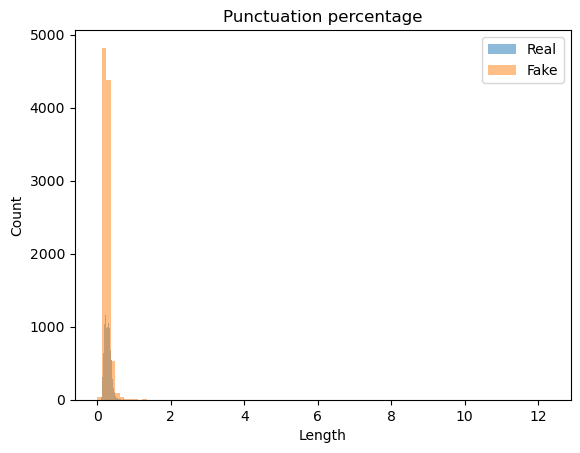

Punctuation percentage in real data:  0.27882113950275644
Punctuation percentage in generated data:  0.2636612338756199


In [284]:

real_plt = real_f["punctuation_percentage"].apply(lambda x: x)
generated_plt = generated_f["punctuation_percentage"].apply(lambda x: x)
plt.hist(real_plt, bins=100, alpha=0.5, label='Real')
plt.hist(generated_plt, bins=100, alpha=0.5, label='Fake')

plt.title('Punctuation percentage')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

avg_real = real_f["punctuation_percentage"].mean()
avg_generated = generated_f["punctuation_percentage"].mean()

print("Punctuation percentage in real data: ", avg_real)
print("Punctuation percentage in generated data: ", avg_generated)



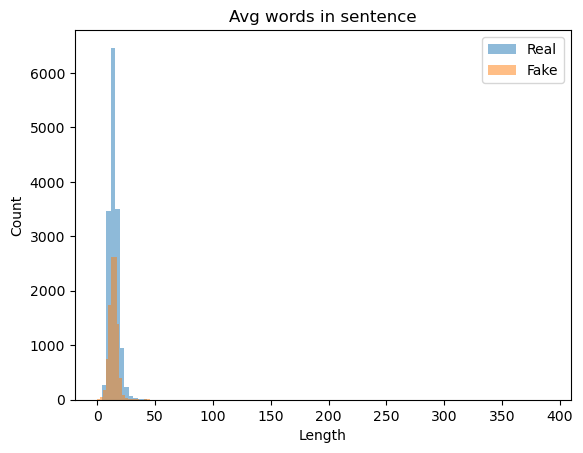

Average words per sentence in real data:  14.517699113302195
Average words per sentence in generated data:  14.157314727891958


In [285]:
real_plt = real_f["average_words_in_sentence"].apply(lambda x: x)
generated_plt = generated_f["average_words_in_sentence"].apply(lambda x: x)
plt.hist(real_plt, bins=100, alpha=0.5, label='Real')
plt.hist(generated_plt, bins=100, alpha=0.5, label='Fake')

plt.title('Avg words in sentence')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

avg_real = real_f["average_words_in_sentence"].mean()
avg_generated = generated_f["average_words_in_sentence"].mean()

print("Average words per sentence in real data: ", avg_real)
print("Average words per sentence in generated data: ", avg_generated)

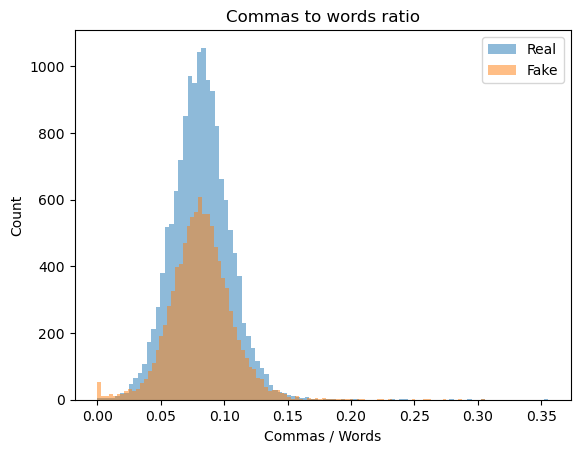

Average commas to words in real data:  0.0817421935071178
Average commas to words in generated data:  0.08155594995474591


In [290]:
real_plt = real_f["commas_to_words"].apply(lambda x: x)
generated_plt = generated_f["commas_to_words"].apply(lambda x: x)
plt.hist(real_plt, bins=100, alpha=0.5, label='Real')
plt.hist(generated_plt, bins=100, alpha=0.5, label='Fake')

plt.title('Commas to words ratio')
plt.xlabel('Commas / Words')
plt.ylabel('Count')
plt.legend()
plt.show()

avg_real = real_f["commas_to_words"].mean()
avg_generated = generated_f["commas_to_words"].mean()

print("Average commas to words in real data: ", avg_real)
print("Average commas to words in generated data: ", avg_generated)

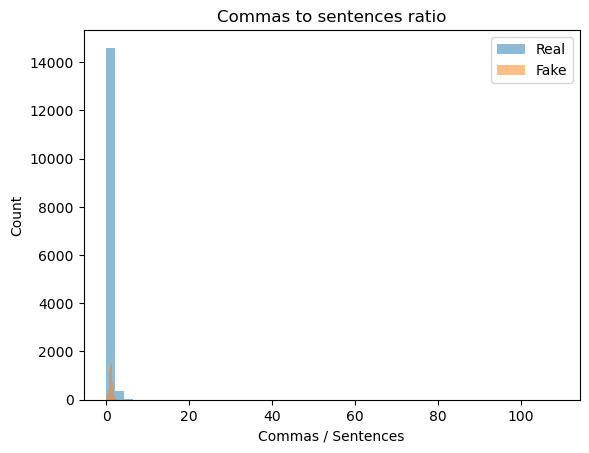

Average commas to sentences in real data:  1.1932344943678088
Average commas to sentences in generated data:  1.1488812523805516


In [ ]:
real_plt = real_f["commas_to_sentences"].apply(lambda x: x)
generated_plt = generated_f["commas_to_sentences"].apply(lambda x: x)
plt.hist(real_plt, bins=50, alpha=0.5, label='Real')
plt.hist(generated_plt, bins=50, alpha=0.5, label='Fake')

plt.title('Commas to sentences ratio')
plt.xlabel('Commas / Sentences')
plt.ylabel('Count')
plt.legend()
plt.show()

avg_real = real_f["commas_to_sentences"].mean()
avg_generated = generated_f["commas_to_sentences"].mean()

print("Average commas to sentences in real data: ", avg_real)
print("Average commas to sentences in generated data: ", avg_generated)

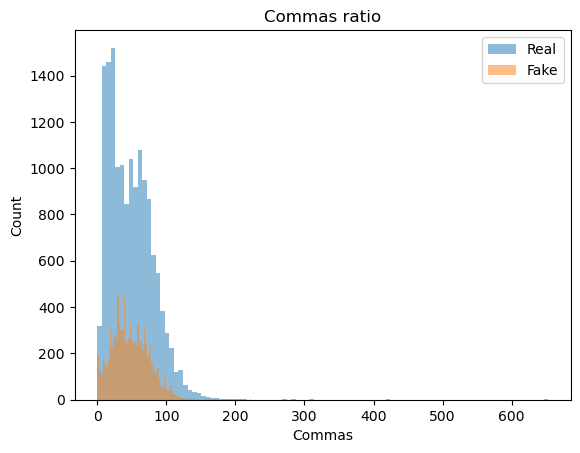

Average commas in real data:  48.51006666666667
Average commas in generated data:  48.36645213193886


In [ ]:
real_plt = real_f["comma_count"].apply(lambda x: x)
generated_plt = generated_f["comma_count"].apply(lambda x: x)
plt.hist(real_plt, bins=100, alpha=0.5, label='Real')
plt.hist(generated_plt, bins=100, alpha=0.5, label='Fake')

plt.title('Commas ratio')
plt.xlabel('Commas')
plt.ylabel('Count')
plt.legend()
plt.show()

avg_real = real_f["comma_count"].mean()
avg_generated = generated_f["comma_count"].mean()

print("Average commas in real data: ", avg_real)
print("Average commas in generated data: ", avg_generated)

In [245]:
### Check the differences in commas percentage

real_f = df[df['labels'] == 1]
generated_f = df[df['labels'] == 0]
r_f = real_f[real_f['sentence_count'] == 50]
f_f = generated_f[generated_f['sentence_count'] == 50]

print(r_f.shape, f_f.shape)

real_9000 = r_f["comma_count"][:381]
generated_9000 = f_f["comma_count"][:381]

print(real_9000.shape, generated_9000.shape)

sum_real_9000 = real_9000.sum()
sum_generated_9000 = generated_9000.sum()

avg_real_9000 = sum_real_9000 / (sum_real_9000 + sum_generated_9000)
avg_generated_9000 = sum_generated_9000 / (sum_real_9000 + sum_generated_9000)

print("Commas in real data / Commas in all data (%): ", avg_real_9000 * 100 )
print("Commas in generated data / Commas in all data (%): ", avg_generated_9000 * 100)

(381, 12) (1970, 12)
(381,) (381,)
Commas in real data / Commas in all data (%):  48.116591928251125
Commas in fake data / Commas in all data (%):  51.88340807174888


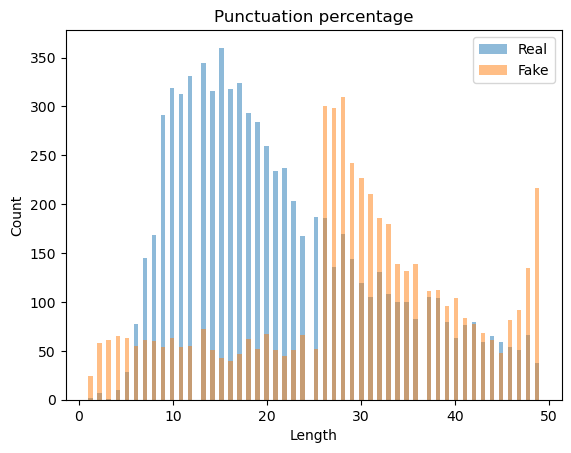

Sentences in real data:  21.3692492332311 21.3692492332311
Sentences in generated data:  28.838908801274393 28.838908801274393


In [289]:
real_f = df[df['labels'] == 1]
generated_f = df[df['labels'] == 0]
r_f = real_f[real_f['sentence_count'] < 50]
f_f = generated_f[generated_f['sentence_count'] < 50]

real_plt = r_f["sentence_count"].apply(lambda x: x)
generated_plt = f_f["sentence_count"].apply(lambda x: x)
plt.hist(real_plt, bins=100, alpha=0.5, label='Real')
plt.hist(generated_plt, bins=100, alpha=0.5, label='Fake')

plt.title('Punctuation percentage')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

avg_real = r_f["sentence_count"].mean()
avg_fake = f_f["sentence_count"].mean()

print("Sentences in real data: ", avg_real, avg_real.mean())
print("Sentences in generated data: ", avg_fake, avg_fake.mean())


____

### Write to file after text preprocessing

In [303]:
df["article"] = df["preprocessed_article"]
df.drop(columns=['preprocessed_article'], inplace=True)
df.to_csv('preprocessed_articles.csv')